In [133]:
import numpy as np 
import corner as DFM

from astroML.density_estimation import XDGMM
from sklearn.mixture import GaussianMixture as GMix
from extreme_deconvolution import extreme_deconvolution
from scipy.stats import multivariate_normal as MNorm

import env
import catalogs as Cats
from fstarforms import fstarforms
from fstarforms import xdGMM

ImportError: cannot import name xdGMM

In [65]:
import matplotlib as mpl
import matplotlib.pyplot as plt 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [111]:
Cat = Cats.Catalog()
_logM, _logSFR, w, censat = Cat.Read('illustris_100myr')
iscen = (censat == 1)
logM = _logM[iscen]
logSFR = _logSFR[iscen]

logSFR_err = 0.434*(2.e-2)/(10.**logSFR)


------ illustris_100myr ------
16943 of 66808 galaxies have 0/non-finite SFRs
logSFR of these galaxies will be -999.
/Users/chang/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in divide
  import sys


In [113]:
mlim = (logM > 10.0) & (logM < 10.2) & (np.isfinite(logSFR_err))

(-2.5, 0.75)

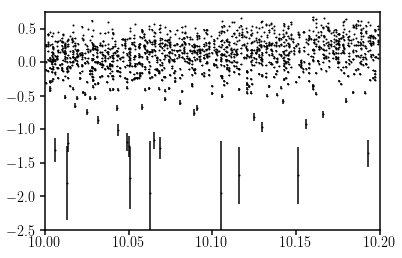

In [115]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(logM[mlim], logSFR[mlim], yerr=logSFR_err[mlim], fmt='.k', markersize=2)
sub.set_xlim([10., 10.2])
sub.set_ylim([-2.5, 0.75])

In [87]:
xdgmm = XDGMM(3, n_iter=500)

In [98]:
X = np.reshape((logSFR[mlim] - logM[mlim]), (-1, 1))
Xerr = np.zeros(X.shape + X.shape[-1:])
Xerr[:,0,0] = logSFR_err[mlim]
xdgmm.fit(X, Xerr)

/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecatio

(-13.0, -9)

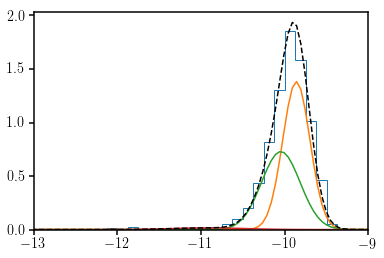

In [106]:
xx = np.linspace(-14., -9., 100)
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(logSFR[mlim] - logM[mlim], normed=True, histtype='step', range=[-13., -9], bins=32)
for icomp in range(len(xdgmm.mu)): 
    sub.plot(xx, xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp]))
    if icomp == 0: 
        gtot = xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp])
    else: 
        gtot += xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp])
sub.plot(xx, gtot, c='k', ls='--')
sub.set_xlim([-13., -9])

In [116]:
mlim = (logM > 11.0) & (logM < 11.2) & (np.isfinite(logSFR_err))

(-2.5, 0.75)

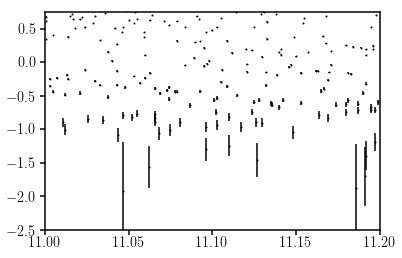

In [117]:
fig = plt.figure()
sub = fig.add_subplot(111)
sub.errorbar(logM[mlim], logSFR[mlim], yerr=logSFR_err[mlim], fmt='.k', markersize=2)
sub.set_xlim([11., 11.2])
sub.set_ylim([-2.5, 0.75])

In [127]:
xdgmm = XDGMM(3, n_iter=500)
X = np.reshape((logSFR[mlim] - logM[mlim]), (-1, 1))
Xerr = np.zeros(X.shape + X.shape[-1:])
Xerr[:,0,0] = logSFR_err[mlim]
xdgmm.fit(X, Xerr)

/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chang/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecatio

(-13.0, -9)

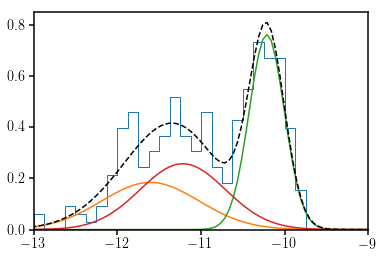

In [128]:
xx = np.linspace(-14., -9., 100)
fig = plt.figure()
sub = fig.add_subplot(111)
_ = sub.hist(logSFR[mlim] - logM[mlim], normed=True, histtype='step', range=[-13., -9], bins=32)
for icomp in range(len(xdgmm.mu)): 
    sub.plot(xx, xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp]))
    if icomp == 0: 
        gtot = xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp])
    else: 
        gtot += xdgmm.alpha[icomp]*MNorm.pdf(xx, xdgmm.mu[icomp], xdgmm.V[icomp])
sub.plot(xx, gtot, c='k', ls='--')
sub.set_xlim([-13., -9])

In [129]:
xdgmm.logL(X, Xerr)

31.8243214412398

In [132]:
gmm = GMix(n_components=3)
gmm.fit(X)
print gmm.score(X)*X.shape[0]

-256.424919278
